<div style="text-align: center;">
    <h1>XGBoost On Loan Repayment Prediction</h1>
    </div>
</div>

# 1. Introduction

In this assignment, we aim to develop a predictive model to assess the likelihood of loan defaults using the XGBoost algorithm. The primary objective is to identify key factors that influence loan repayment outcomes and evaluate the model's performance using appropriate metrics. Additionally, we explore the effectiveness of other models, such as Logistic Regression and K-Means clustering, to compare their performance against XGBoost. By leveraging advanced machine learning techniques, we seek to provide a robust solution for predicting loan defaults, which can aid financial institutions in making informed lending decisions.

# 2. XGBoost Model

We used the XGBoost (Extreme Gradient Boosting) model to predict whether a given person will be able to repay a loan. The model builds an ensemble of decision trees sequentially, where each new tree attempts to correct the errors made by the previous trees. The model uses gradient descent to minimize the loss function, which in this case is the logistic loss for binary classification.

## 2.1 Model Formula

The XGBoost model for binary classification can be illustrated as follows:

$$
\hat{y} = \sum_{m=1}^{M} f_m(x)
$$

where:

- $\hat{y}$ is the predicted probability of the positive class (loan repaid successfully).
- $M$ is the total number of trees.
- $f_m(x)$ is the prediction from the $m$-th tree.

## 2.2 Loss Function
<br>
The logistic loss function for binary classification is defined as:

$$
L(y, \hat{y}) = - \left[ y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right]
$$

where:

- $y$ is the actual class label (0 or 1).
- $\hat{y}$ is the predicted probability of the positive class.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression

!pip install --upgrade scikit-learn threadpoolctl
!pip install --upgrade numpy scikit-learn threadpoolctl


  Using cached numpy-2.2.4-cp310-cp310-win_amd64.whl (12.9 MB)


# 3. Data Overview

## 3.1 Data Source

We used the bank loan data from Kaggle website ([Link](https://www.kaggle.com/datasets/udaymalviya/bank-loan-data/data)).This dataset contains 45,000 records of loan applicants, with various attributes related to personal demographics, financial status, and loan details. We used this dataset for loan default prediction.

The dataset includes 14 columns representing different factors influencing loan approvals and defaults. Below is an overview of the dataset.

| Category                  | Feature                        | Description                                                                                   |
|:--------------------------|:-------------------------------|:----------------------------------------------------------------------------------------------|
| **Personal Information**  | person_age                     | Age of the applicant (in years).                                                              |
|                           | person_gender                  | Gender of the applicant (male, female).                                                       |
|                           | person_education               | Educational background (High School, Bachelor, Master, etc.).                                  |
|                           | person_income                  | Annual income of the applicant (in USD).                                                      |
|                           | person_emp_exp                 | Years of employment experience.                                                               |
|                           | person_home_ownership          | Type of home ownership (RENT, OWN, MORTGAGE).                                                 |
| **Loan Details**          | loan_amnt                      | Loan amount requested (in USD).                                                               |
|                           | loan_intent                    | Purpose of the loan (PERSONAL, EDUCATION, MEDICAL, etc.).                                      |
|                           | loan_int_rate                  | Interest rate on the loan (percentage).                                                       |
|                           | loan_percent_income            | Ratio of loan amount to income.                                                               |
| **Credit & Loan History** | cb_person_cred_hist_length     | Length of the applicant's credit history (in years).                                          |
|                           | credit_score                   | Credit score of the applicant.                                                                |
|                           | previous_loan_defaults_on_file | Whether the applicant has previous loan defaults (Yes or No).                                 |
| **Target Variable**       | loan_status                    | 1 if the loan was repaid successfully, 0 if the applicant defaulted.                          |


## 3.2 Data Cleaning

### 3.2.1 Summary Statistics

In [2]:
# Load the dataset
df = pd.read_csv('loan_data.csv')

In [3]:
# Summary statistics for numerical features
print(df.describe())

# Summary statistics for categorical features
print(df.describe(include=['O']))

         person_age  person_income  person_emp_exp     loan_amnt  \
count  45000.000000   4.500000e+04    45000.000000  45000.000000   
mean      27.764178   8.031905e+04        5.410333   9583.157556   
std        6.045108   8.042250e+04        6.063532   6314.886691   
min       20.000000   8.000000e+03        0.000000    500.000000   
25%       24.000000   4.720400e+04        1.000000   5000.000000   
50%       26.000000   6.704800e+04        4.000000   8000.000000   
75%       30.000000   9.578925e+04        8.000000  12237.250000   
max      144.000000   7.200766e+06      125.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   45000.000000         45000.000000                45000.000000   
mean       11.006606             0.139725                    5.867489   
std         2.978808             0.087212                    3.879702   
min         5.420000             0.000000                    2.000000   
25%         8.590000  

In [4]:
# Identify data points where person_age is over 100
age_over_100 = df[df['person_age'] > 100]

# Print only the person_age and person_emp_exp variables for these data points
print(age_over_100[['person_age', 'person_emp_exp']])

# Identify the indices to be dropped (i.e. age > 122)
indices_to_drop = [81, 183, 575, 747, 32297]

# Drop the specified rows (i.e. age > 122)
df = df.drop(indices_to_drop)

# Print the summary statistics for the person_age and person_emp_exp columns
# Validate that the data range of person_emp_exp from the updated dataset is appropriate (e.g., max = 93)
print(df[['person_age', 'person_emp_exp']].describe())

       person_age  person_emp_exp
81            144             125
183           144             121
575           123             101
747           123             100
32297         144             124
37930         116              93
38113         109              85
         person_age  person_emp_exp
count  44995.000000    44995.000000
mean      27.752195        5.398244
std        5.936603        5.953239
min       20.000000        0.000000
25%       24.000000        1.000000
50%       26.000000        4.000000
75%       30.000000        8.000000
max      116.000000       93.000000


### 3.2.2 Missing Values

In [5]:
# Detect missing values in the revised dataset
missing_values = df.isnull().sum()

# Print the count of missing values for each column
# No missing value observed
print(missing_values)

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


### 3.2.3 Check Data Types

In [6]:
# Check current data types
print("Current Data Types:\n", df.dtypes)

Current Data Types:
 person_age                          int64
person_gender                      object
person_education                   object
person_income                       int64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                           int64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length          int64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object


In [7]:
# Summary statistics for the updated numerical features
print(df.describe())

# Summary statistics for the updated categorical features
print(df.describe(include=['O']))

         person_age  person_income  person_emp_exp     loan_amnt  \
count  44995.000000   4.499500e+04    44995.000000  44995.000000   
mean      27.752195   8.015163e+04        5.398244   9582.973441   
std        5.936603   7.307509e+04        5.953239   6314.740894   
min       20.000000   8.000000e+03        0.000000    500.000000   
25%       24.000000   4.719650e+04        1.000000   5000.000000   
50%       26.000000   6.704600e+04        4.000000   8000.000000   
75%       30.000000   9.578250e+04        8.000000  12236.000000   
max      116.000000   5.556399e+06       93.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   44995.000000          44995.00000                44995.000000   
mean       11.006508              0.13973                    5.867319   
std         2.978933              0.08721                    3.878769   
min         5.420000              0.00000                    2.000000   
25%         8.590000  

In [8]:
# Define feature groups based on the dataset table

# Personal Information features
personal_info_features = [
    'person_age',
    'person_gender',
    'person_education',
    'person_income',
    'person_emp_exp',
    'person_home_ownership'
]

# Loan Details features
loan_details_features = [
    'loan_amnt',
    'loan_intent',
    'loan_int_rate',
    'loan_percent_income'
]

# Credit & Loan History features
credit_loan_history_features = [
    'cb_person_cred_hist_length',
    'credit_score',
    'previous_loan_defaults_on_file'
]


## 3.3 Preliminary Exploratory Analysis

So far, we have cleaned the data. Below is a summary of the steps we took.

- Summary Statistics
    - Age Data Errors: We observed the potential data errors in the person_age column.Based on research, the longest-lived person was 122 years old. However, our dataset includes ages greater than this limit. We identified and dropped 5 rows where person_age was greater than 122.
    - Employment Experience Range: We also cross-checked the person_emp_exp column after we dropped 5 rows and verified that the maximum value (around 93) is sensible and does not indicate a problem.

- Missing Values: We checked the updated dataset for any missing values and confirmed that there are no missing values in the dataset.

- Data Types: We reviewed the data types of all columns and confirmed that the data types are appropriate and do not require adjustments.

Next, we would like to perform preliminary exploratory analysis by plotting some visualizations. The goal of these visualizations is to understand the quality and characteristics of the data, which in turn affects the accuracy and performance of the model we want to build. By examining distributions and correlations, we can identify patterns, outliers, and relationships that are important for building a robust predictive model.

### 3.3.1 Distribution Plots

**Distribution Plots on default status**

loan_status
0    34995
1    10000
Name: count, dtype: int64


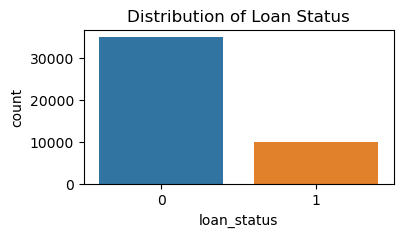

In [9]:
# Distribution of Loan Default vs. Non-Default
# Accurate counts of loan status
loan_status_counts = df['loan_status'].value_counts()
print(loan_status_counts)

plt.figure(figsize=(4, 2))
sns.countplot(x='loan_status', data=df)
plt.title('Distribution of Loan Status')
plt.show()

**Based on the above plot, we have the below obersavtion:**

- Loan Status: There are over 30,000 instances of loans that were defaulted while there are 10,000 instances of loans that were repaid successfully.

**Potential Issue:**
- Imbalanced Data: The dataset shows a significant imbalance between defaulted and repaid loans, which can potentially lead to biased models and poor performance on the minority class.

**Distribution Plots on the features**

C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


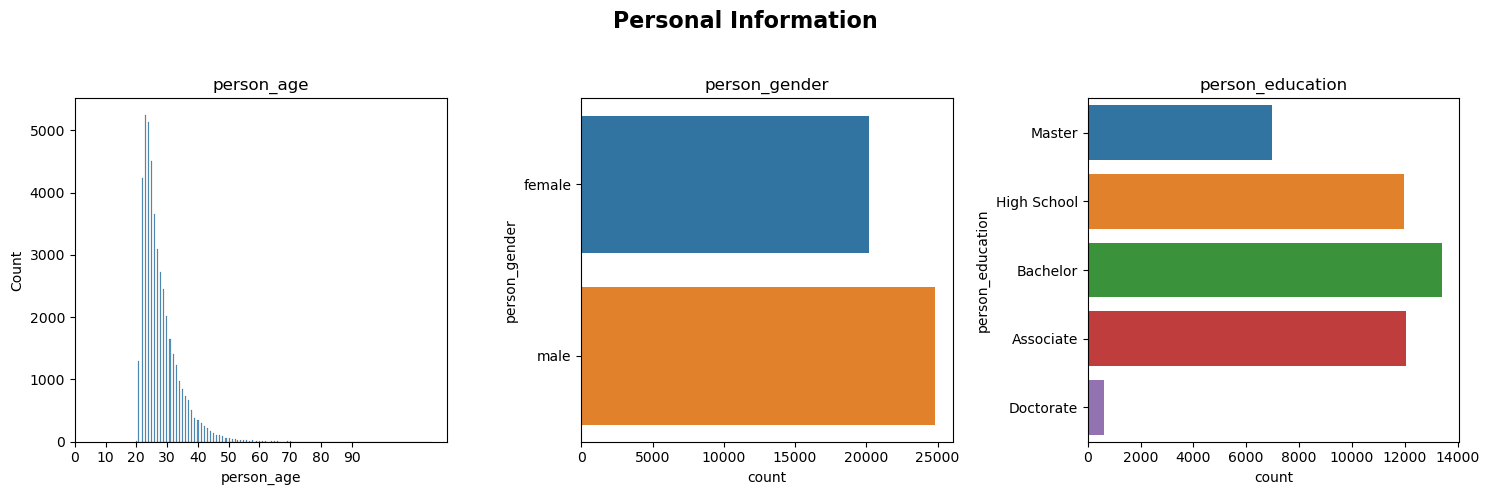

C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


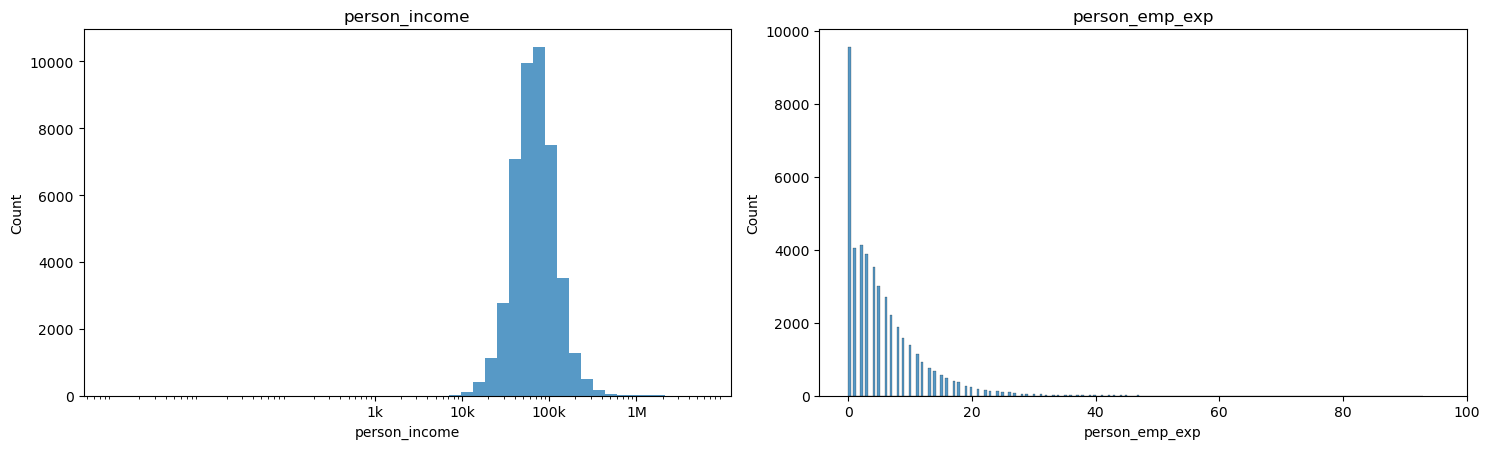

C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


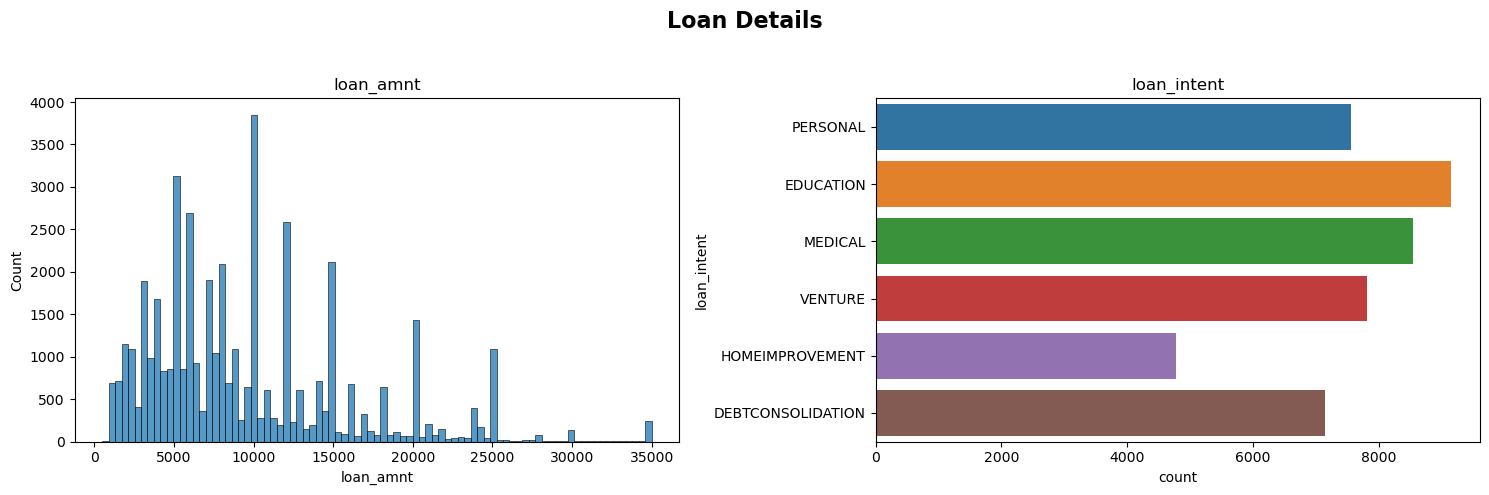

C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


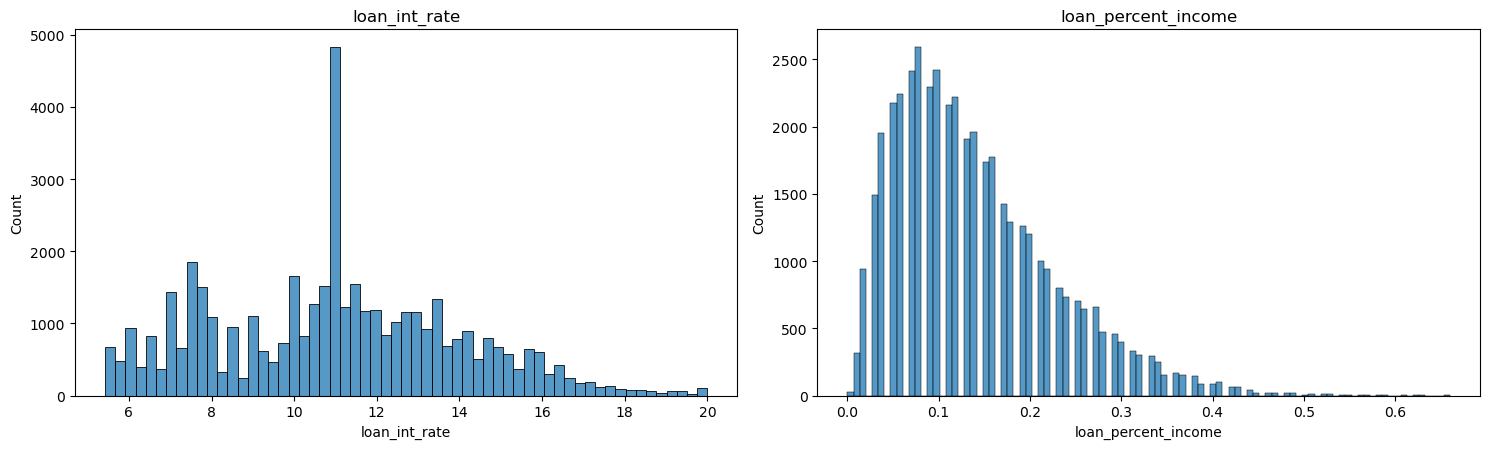

C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


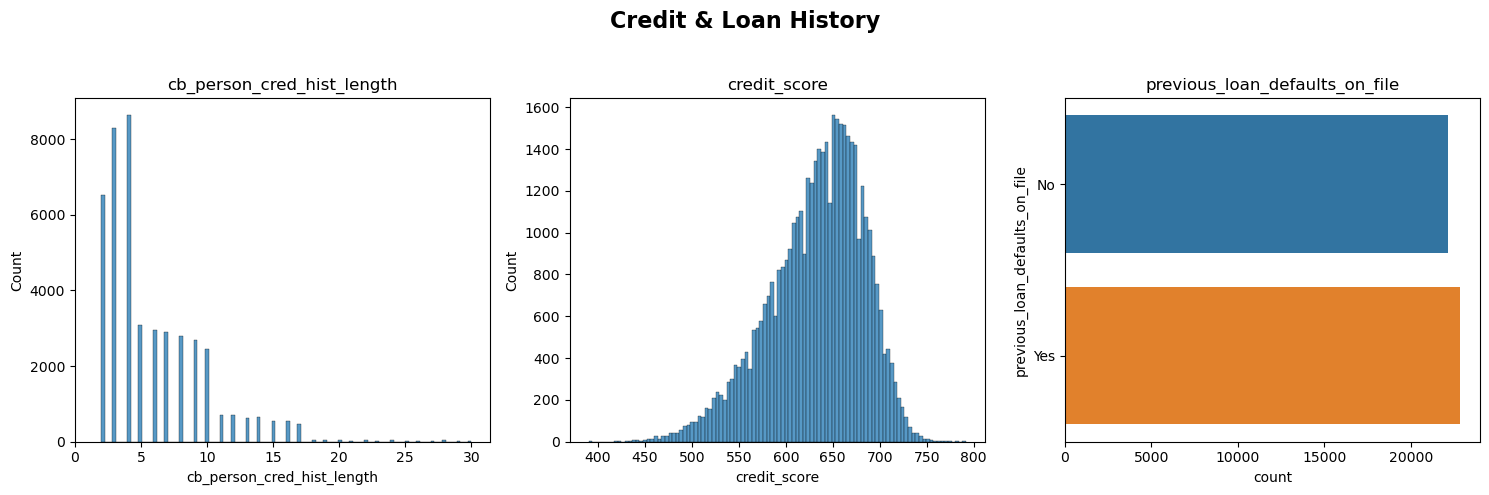

In [10]:
def plot_features(features, nrows, ncols, title):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5*nrows))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    axes = axes.flatten()

    for ax, feature in zip(axes, features):
        if df[feature].dtype == 'object':
            sns.countplot(y=feature, data=df, ax=ax)
        else:
            if feature == 'person_income':
                # Use logarithmic scale for better visualization
                sns.histplot(df[feature], kde=False, ax=ax, bins=np.logspace(np.log10(1), np.log10(df[feature].max()), num=50))
                ax.set_xscale('log')
                ax.set_xticks([1000, 10000, 100000, 1000000])
                ax.set_xticklabels(['1k', '10k', '100k', '1M'])
            else:
                sns.histplot(df[feature], kde=False, ax=ax)
                # Customize x-axis for better readability
                if feature == 'person_age':
                    ax.set_xticks(range(0, 91, 10))
                elif feature == 'person_emp_exp':
                    ax.set_xticks(range(0, 101, 20))
                elif feature == 'cb_person_cred_hist_length':
                    ax.set_xticks(range(0, 35, 5))
        ax.set_title(feature)

    # Hide any unused subplots
    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot Personal Information features
plot_features(personal_info_features[:3], 1, 3, 'Personal Information')
plot_features(personal_info_features[3:], 1, 2, '')

# Plot Loan Details features
plot_features(loan_details_features[:2], 1, 2, 'Loan Details')
plot_features(loan_details_features[2:], 1, 2, '')

# Plot Credit & Loan History features
plot_features(credit_loan_history_features, 1, 3, 'Credit & Loan History')

In [11]:
# Define age bins and labels
age_bins = [20, 30, 40, 50, 60, float('inf')]
age_labels = ['20-30', '30-40', '40-50', '50-60', '60+']

# Create a new column 'age_group' with the age categories
df['age_group'] = pd.cut(df['person_age'], bins=age_bins, labels=age_labels, right=False)

# Count the number of occurrences in each age group
age_group_counts = df['age_group'].value_counts().sort_index()

print(age_group_counts)

age_group
20-30    32378
30-40    10434
40-50     1804
50-60      290
60+         89
Name: count, dtype: int64


**Based on the above plots and the previous summary statistics, we have the below observations.**

- Personal Information:
    - Age (person_age): The age distribution is concentrated around the mid-20s, with a mean age of around 28 years old.
    - Gender (person_gender): The distribution is slightly skewed towards males.
    - Education (person_education): The majority of applicants have a Bachelor's degree, followed by High School degree, Master degree, Associate degree, and Doctorate degree.
    - Income (person_income): The income distribution is mostly concentrated around USD 100,000, with a median of USD 67,046.
    - Employment Experience (person_emp_exp): The employment experience ranges from 0 to 30 years, where most of the people have limited employment experience, with a median of 5.4 years.
    - Home Ownership (person_home_ownership): Most applicants either rent or have mortgage for their homes, with fewer owning their homes.

- Loan Details:
    - Loan Amount (loan_amnt): The loan amount distribution shows a higher frequency of smaller loans, with a mean loan amount of approximately USD 8,000 and a maximum of USD 35,000.
    - Loan Intent (loan_intent): There are different intents of the loans, such as eduaction, medical, venture, debtonsolidation, home improvement and others purposes.
    - Interest Rate (loan_int_rate): The interest rate distribution is fairly normal, with a median rate of approximately 11.01% and most rates falling between 8.59% and 12.99%.
    - Loan Percent Income (loan_percent_income): The ratio of loan amount to income is generally low, with a median of 0.12 and most values below 0.19.

- Credit & Loan History:
    - Credit History Length (cb_person_cred_hist_length): The length of credit history ranges from 2 to 30 years, with a median of approximately 4 years.
    - Credit Score (credit_score): The credit score distribution is left-skewed, with a median score of approximately 640 and most scores between 601 and 670.
    - Previous Loan Defaults (previous_loan_defaults_on_file): The number of applicants have previous loan defaults and those who have not are similar.
    
**Potential Issue**
- Young Population Dominance Skewness: The dataset is dominated by younger individuals (20-30 age group), which may not represent the broader population and could bias the model towards the financial behaviors and risks of younger adults.

### 3.3.2 Correlation Plots

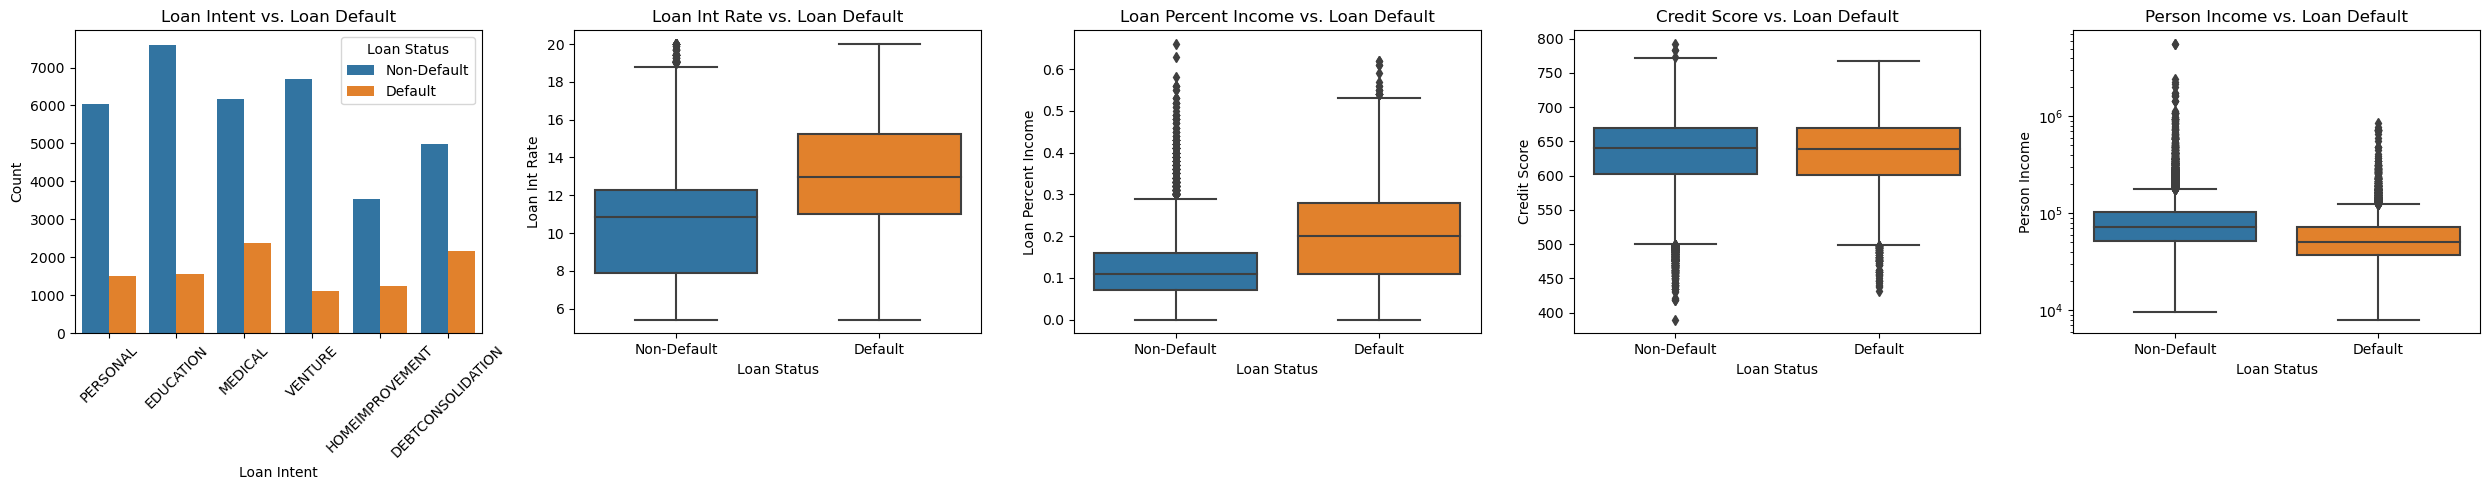

In [12]:
# Create a list of tuples containing the feature and the plot type
plot_features = [
    ('loan_intent', 'countplot'),
    ('loan_int_rate', 'boxplot'),
    ('loan_percent_income', 'boxplot'),
    ('credit_score', 'boxplot'),
    ('person_income', 'boxplot')
]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))

# Loop through the features and create the plots
for i, (feature, plot_type) in enumerate(plot_features):
    if plot_type == 'countplot':
        sns.countplot(x=feature, hue='loan_status', data=df, ax=axes[i])
        axes[i].set_title(f'{feature.replace("_", " ").title()} vs. Loan Default')
        axes[i].set_xlabel(feature.replace("_", " ").title())
        axes[i].set_ylabel('Count')
        axes[i].legend(title='Loan Status', loc='upper right', labels=['Non-Default', 'Default'])
        axes[i].tick_params(axis='x', rotation=45)
    elif plot_type == 'boxplot':
        sns.boxplot(x='loan_status', y=feature, data=df, ax=axes[i])
        axes[i].set_title(f'{feature.replace("_", " ").title()} vs. Loan Default')
        axes[i].set_xlabel('Loan Status')
        axes[i].set_ylabel(feature.replace("_", " ").title())
        axes[i].set_xticklabels(['Non-Default', 'Default'])
        if feature == 'person_income':
            axes[i].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()

**Based on the above plots, we have the below observation.**

- Loan Intent vs. Loan Default:
    - Distribution is similar across intents; no significant issues.
- Loan Interest Rate vs. Loan Default:
    - Defaulted loans have slightly higher interest rates.
- Loan Percent Income vs. Loan Default:
    - Defaulted loans have a higher loan percent income.
- Credit Score vs. Loan Default:
    - Defaulted loans have lower credit scores.
- Person Income vs. Loan Default:
    - Defaulted loans have lower personal incomes.
    
**Potential Issue**
- No major issues observed. Key factors associated with defaults are higher interest rates, higher loan percent income, lower credit scores, and lower incomes.

# 4. Modeling

### Model Set Up

In [13]:
# Define feature columns: all columns except 'loan_status'
feature_cols = [col for col in df.columns if col != 'loan_status']  # Include all except target
X = df[feature_cols]
y = df['loan_status']

# Identify categorical columns (including any derived ones like 'age_group')
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns identified:", categorical_cols)

# Convert categorical variables to numerical using one-hot encoding
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Verify all columns are numeric
print("Data types after encoding:\n", X.dtypes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Categorical columns identified: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file', 'age_group']
Data types after encoding:
 person_age                              int64
person_income                           int64
person_emp_exp                          int64
loan_amnt                               int64
loan_int_rate                         float64
loan_percent_income                   float64
cb_person_cred_hist_length              int64
credit_score                            int64
person_gender_male                       bool
person_education_Bachelor                bool
person_education_Doctorate               bool
person_education_High School             bool
person_education_Master                  bool
person_home_ownership_OTHER              bool
person_home_ownership_OWN                bool
person_home_ownership_RENT               bool
loan_intent_EDUCATION                    bool
loan_intent_HOMEIMPROVEMENT      

In [14]:
# Initialize the XGBoost model with basic parameters
xgb_model = XGBClassifier(
    objective='binary:logistic',  # For binary classification
    eval_metric='auc',            # Use AUC as the evaluation metric
    use_label_encoder=False,      # Avoids label encoding warning
    random_state=42               # For reproducibility
)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Print confirmation
print("Initial XGBoost model trained successfully.")

C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [15:13:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Initial XGBoost model trained successfully.


### Initialize the model

In [15]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    early_stopping_rounds = 10,
    learning_rate=0.1,    # Lower learning rate for robustness
    max_depth=5,          # Moderate depth
    min_child_weight=1,   # Default value
    n_estimators=1000     # High value, we’ll stop early manually
)

# Split training data into a sub-training and validation set
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Fit the model with evaluation set
xgb_model.fit(
    X_train_sub,
    y_train_sub,
    eval_set=[(X_val, y_val)],
    verbose=True  # Print AUC for each iteration
)

# Get the evaluation results
evals_result = xgb_model.evals_result()
val_auc = evals_result['validation_0']['auc']

# Find the best iteration (highest AUC)
best_iteration = val_auc.index(max(val_auc)) + 1  # +1 because index starts at 0
print(f"Best number of trees (n_estimators): {best_iteration}")
print(f"Best validation AUC: {max(val_auc):.4f}")

[0]	validation_0-auc:0.95576
[1]	validation_0-auc:0.96077
[2]	validation_0-auc:0.96046
[3]	validation_0-auc:0.96175
[4]	validation_0-auc:0.96314
[5]	validation_0-auc:0.96333
[6]	validation_0-auc:0.96405
[7]	validation_0-auc:0.96482
[8]	validation_0-auc:0.96498
[9]	validation_0-auc:0.96503
[10]	validation_0-auc:0.96564
[11]	validation_0-auc:0.96588
[12]	validation_0-auc:0.96678
[13]	validation_0-auc:0.96685


C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\xgboost\callback.py:386: UserWarning: [15:13:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[14]	validation_0-auc:0.96756
[15]	validation_0-auc:0.96770
[16]	validation_0-auc:0.96787
[17]	validation_0-auc:0.96829
[18]	validation_0-auc:0.96868
[19]	validation_0-auc:0.96877
[20]	validation_0-auc:0.96912
[21]	validation_0-auc:0.96932
[22]	validation_0-auc:0.96972
[23]	validation_0-auc:0.96996
[24]	validation_0-auc:0.97016
[25]	validation_0-auc:0.97033
[26]	validation_0-auc:0.97034
[27]	validation_0-auc:0.97059
[28]	validation_0-auc:0.97077
[29]	validation_0-auc:0.97093
[30]	validation_0-auc:0.97099
[31]	validation_0-auc:0.97109
[32]	validation_0-auc:0.97122
[33]	validation_0-auc:0.97127
[34]	validation_0-auc:0.97149
[35]	validation_0-auc:0.97156
[36]	validation_0-auc:0.97161
[37]	validation_0-auc:0.97165
[38]	validation_0-auc:0.97173
[39]	validation_0-auc:0.97185
[40]	validation_0-auc:0.97194
[41]	validation_0-auc:0.97199
[42]	validation_0-auc:0.97208
[43]	validation_0-auc:0.97220
[44]	validation_0-auc:0.97232
[45]	validation_0-auc:0.97235
[46]	validation_0-auc:0.97238
[47]	valid

[282]	validation_0-auc:0.97960
[283]	validation_0-auc:0.97962
[284]	validation_0-auc:0.97964
[285]	validation_0-auc:0.97962
[286]	validation_0-auc:0.97960
[287]	validation_0-auc:0.97964
[288]	validation_0-auc:0.97963
[289]	validation_0-auc:0.97966
[290]	validation_0-auc:0.97967
[291]	validation_0-auc:0.97969
[292]	validation_0-auc:0.97969
[293]	validation_0-auc:0.97969
[294]	validation_0-auc:0.97971
[295]	validation_0-auc:0.97970
[296]	validation_0-auc:0.97971
[297]	validation_0-auc:0.97971
[298]	validation_0-auc:0.97971
[299]	validation_0-auc:0.97973
[300]	validation_0-auc:0.97972
[301]	validation_0-auc:0.97971
[302]	validation_0-auc:0.97969
[303]	validation_0-auc:0.97971
[304]	validation_0-auc:0.97971
[305]	validation_0-auc:0.97970
[306]	validation_0-auc:0.97969
[307]	validation_0-auc:0.97969
[308]	validation_0-auc:0.97973
[309]	validation_0-auc:0.97972
Best number of trees (n_estimators): 300
Best validation AUC: 0.9797


We conducted an initial model training with early stopping to get an idea of how many trees (n_estimators) the model might need to achieve good performance without overfitting. We used a single train-validation split to monitor the performance and stopped training when the validation performance stopped improving.

As we can see from the above result, the best number of trees is 300 and the best validation AUC is 0.9797 based on this single validation set.

###  Refine the model

In [16]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],              # Test shallower and deeper trees
    'min_child_weight': [1, 3, 5],       # Control overfitting
    'learning_rate': [0.01, 0.1, 0.2],   # Range from slow to moderate learning
    'n_estimators': [300]                # Fix at best iteration from early stopping
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',         # Use AUC as the metric per homework
    cv=5,                      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1                  # Use all available CPU cores
)

# Fit the grid search on the full training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation AUC:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [15:15:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300}
Best cross-validation AUC: 0.9782610289943359


We further conducted the hyperparameter tuning with cross-validation to find the best combination of parameters that generalize well across multiple folds of the data.

The best cross-validation AUC 0.9783 is obtained by averaging the performance across 5 folds. This AUC is generally more reliable than the single validation AUC because it reflects the model's performance on different subsets of the data.

In [20]:
# Initialize the final XGBoost model with tuned parameters
final_xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    learning_rate=0.2,         # Tuned value
    max_depth=5,               # Tuned value
    min_child_weight=3,        # Tuned value
    n_estimators=300           # Tuned value
)

# Train the model on the full training data
final_xgb_model.fit(X_train, y_train)

# Print confirmation
print("Final XGBoost model trained successfully with tuned parameters.")

C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [15:16:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final XGBoost model trained successfully with tuned parameters.


### Final model

Test set AUC: 0.9787


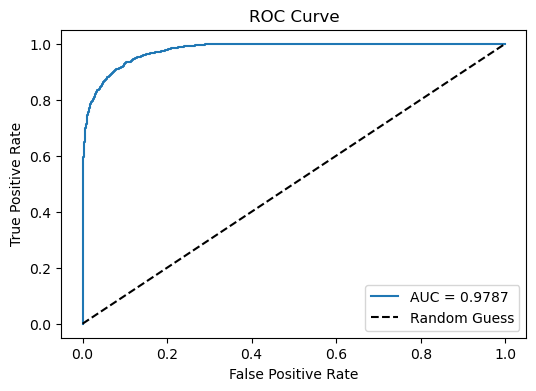

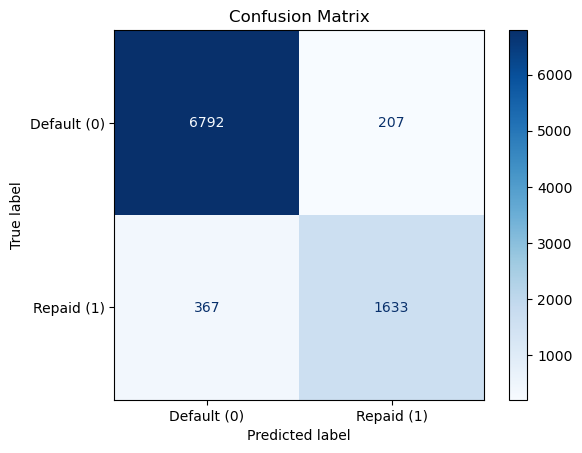

In [21]:
# Predict probabilities on the test set
y_pred_proba = final_xgb_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (loan repaid)

# Compute AUC
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test set AUC: {test_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Predict class labels for confusion matrix
y_pred = final_xgb_model.predict(X_test)

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Default (0)', 'Repaid (1)'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

After finding the best parameters through cross-validation, we trained the final model on the full training data using these parameters.

The final test set AUC of 0.9787 is a good indicator of how well the model performs on completely unseen data. Though this AUC is slightly lower than the initial validation AUC and the cross-validation AUC, it is still very close to 1, which indicates that the model generalizes well.

Top 10 Most Important Features:
                               Feature  Importance
21  previous_loan_defaults_on_file_Yes    0.861063
5                  loan_percent_income    0.021231
15          person_home_ownership_RENT    0.019881
14           person_home_ownership_OWN    0.014297
20                 loan_intent_VENTURE    0.012319
4                        loan_int_rate    0.010905
17         loan_intent_HOMEIMPROVEMENT    0.008708
16               loan_intent_EDUCATION    0.007277
1                        person_income    0.006741
18                 loan_intent_MEDICAL    0.006139


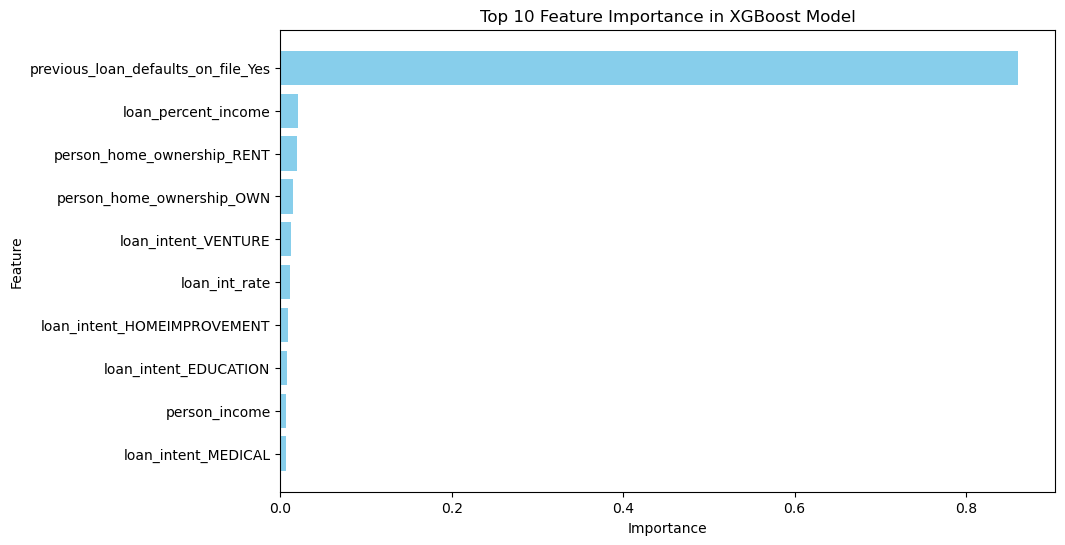

In [22]:
# Get feature importance from the final model
feature_importance = final_xgb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easier handling
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Print top 10 most important features
print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance in XGBoost Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [23]:
X_test_updated = X_test.copy()
X_test_updated['Actual'] = y_test
X_test_updated['Predicted'] = final_xgb_model.predict(X_test)


In [24]:
# Define loan types based on the available columns in X_test
loan_types = [col for col in X_test.columns if col.startswith('loan_intent_')]

# Calculate accuracy for each loan type
accuracy_by_loan_type = {}
for loan_type in loan_types:
    # Filter the test set by loan type
    loan_type_df = X_test_updated[X_test_updated[loan_type] == 1]
    if not loan_type_df.empty:
        # Calculate accuracy
        accuracy = accuracy_score(loan_type_df['Actual'], loan_type_df['Predicted'])
        accuracy_by_loan_type[loan_type] = accuracy

# Print accuracy for each loan type
print("Accuracy by Loan Type:")
for loan_type, accuracy in accuracy_by_loan_type.items():
    print(f"{loan_type}: {accuracy:.4f}")

# Identify the loan type with the lowest accuracy
least_accurate_loan_type = min(accuracy_by_loan_type, key=accuracy_by_loan_type.get)
print("\nLoan Type with the Least Accuracy:")
print(f"{least_accurate_loan_type}: {accuracy_by_loan_type[least_accurate_loan_type]:.4f}")

Accuracy by Loan Type:
loan_intent_EDUCATION: 0.9342
loan_intent_HOMEIMPROVEMENT: 0.9468
loan_intent_MEDICAL: 0.9290
loan_intent_PERSONAL: 0.9168
loan_intent_VENTURE: 0.9673

Loan Type with the Least Accuracy:
loan_intent_PERSONAL: 0.9168


In [25]:
loan_type_df

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,person_gender_male,person_education_Bachelor,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes,age_group_30-40,age_group_40-50,age_group_50-60,age_group_60+,Actual,Predicted
35341,27,129191,4,10932,9.39,0.08,6,658,True,True,...,False,False,True,False,False,False,False,False,0,0
31776,36,168857,12,20800,11.48,0.12,11,680,True,False,...,False,False,True,True,True,False,False,False,0,0
28048,29,53971,4,5400,16.00,0.10,9,582,False,False,...,False,False,True,False,False,False,False,False,1,1
39846,28,102080,3,25000,14.65,0.24,7,620,False,False,...,False,False,True,True,False,False,False,False,0,0
20171,33,48142,13,10000,12.42,0.21,7,680,True,True,...,False,False,True,True,True,False,False,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,25,30184,4,1200,15.21,0.04,4,689,False,True,...,False,False,True,False,False,False,False,False,0,1
14417,22,128097,3,35000,11.01,0.27,2,630,True,False,...,False,False,True,True,False,False,False,False,0,0
7852,26,66718,2,4500,8.49,0.07,3,582,False,True,...,False,False,True,True,False,False,False,False,0,0
8291,22,48144,2,7500,11.01,0.16,4,569,True,False,...,False,False,True,False,False,False,False,False,1,0


In [26]:
# Define the features to compare
features = ['credit_score', 'loan_amnt', 'person_emp_exp', 'loan_int_rate']

# Initialize a dictionary to store the summary statistics
summary_stats = {feature: {} for feature in features}

# Calculate the summary statistics for each loan type
for loan_type in loan_types:
    loan_type_df = X_test[X_test[loan_type] == 1]
    if not loan_type_df.empty:
        for feature in features:
            if feature == 'loan_amnt' or feature == 'loan_int_rate':
                summary_stats[feature][loan_type] = (loan_type_df[feature].min(), loan_type_df[feature].max())
            else:
                summary_stats[feature][loan_type] = loan_type_df[feature].mean()

# Convert the summary statistics dictionary to a DataFrame for better visualization
summary_df = pd.DataFrame(summary_stats)

# Print the summary statistics table
print("\nSummary Statistics by Loan Type:")
print(summary_df)


Summary Statistics by Loan Type:
                             credit_score      loan_amnt  person_emp_exp  \
loan_intent_EDUCATION          629.627586   (912, 35000)        4.343236   
loan_intent_HOMEIMPROVEMENT    635.460334   (500, 35000)        6.344468   
loan_intent_MEDICAL            632.877758   (900, 35000)        5.588551   
loan_intent_PERSONAL           633.330714  (1000, 35000)        5.863785   
loan_intent_VENTURE            633.662216  (1000, 35000)        5.420561   

                            loan_int_rate  
loan_intent_EDUCATION        (5.42, 20.0)  
loan_intent_HOMEIMPROVEMENT  (5.42, 20.0)  
loan_intent_MEDICAL          (5.42, 20.0)  
loan_intent_PERSONAL         (5.42, 20.0)  
loan_intent_VENTURE          (5.42, 20.0)  


# 6. Analysis

So far, we have built a predictive model for loan default using the XGBoost algorithms. Below is a brief recap of steps and findings.

### Summary of data cleaning preliminary exploratory analysis

We removed 5 rows with ages greater than 122, verified that the data does not have missing values, and confirmed the data type accurarcy. Based on our preliminary exploratory analysis, we observed that there is an imbalance between defaulted and repaid loans and a skewness among young population in our dataset. Apart from these two potential issues, we reviewed and ensured that the data are appropriate for modeling.

### Model training and hyperparameter tuning

We performed the initial modeling, hyperparameter tuning using cross validation and final model. Our justification of the choice for the value of the parameters are as below.

| Parameter              | Definition                                                                                     | Justification                                                                                                                                                                                                 |
|:-----------------------|:-----------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **n_estimators**       | The number of boosting rounds (trees in the ensemble).                                          | Determines the number of trees in the ensemble. A higher number of trees can improve model performance but also increases the risk of overfitting. We used early stopping to find the optimal number of trees, which was 300.                         |
| **max_depth**          | The maximum depth of each tree.                                                                 | Controls the complexity of the model. Deeper trees can capture more complex patterns but may overfit the data. We tested a range of values (3, 5, 7) and found that a depth of 5 provided a good balance between complexity and performance.          |
| **min_child_weight**   | The minimum sum of instance weight (hessian) needed in a child.                                 | Helps in controlling overfitting by ensuring that leaf nodes have enough samples. Higher values can make the model more conservative. We tested values like 1, 3, and 5, and found that 3 was optimal for our dataset.                                |
| **learning_rate (eta)**| Step size shrinkage used to prevent overfitting.                                                | A smaller learning rate makes the model more robust to overfitting but requires more trees to achieve good performance. We tested values like 0.01, 0.1, and 0.2, and found that 0.2 provided a good trade-off between learning speed and robustness. |
| **early_stopping_rounds** | The number of rounds to continue training after the validation score stops improving.       | Helps in preventing overfitting by stopping the training process when the model performance on a validation set stops improving. We used a value of 10 rounds, which is a common choice to ensure the model does not overfit.                         |

### Model Assessment

The XGBoost model was evaluated using the Area Under the Receiver Operating Characteristic Curve (AUC-ROC). For our final model, the AUC on the test set was 0.9787, which indicates a strong ability to differentiate between loans that will be repaid and those that will default. This high AUC value suggests that the model performs significantly better than random guessing and is highly capable of predicting loan defaults accurately.

### Confusion Matrix

The confusion matrix indicates that:
- True Negatives (TN): 6792 loans were correctly predicted as defaulted.
- True Positives (TP): 1633 loans were correctly predicted as repaid.
- False Positives (FP): 207 loans were incorrectly predicted as repaid when they actually defaulted.
- False Negatives (FN): 367 loans were incorrectly predicted as defaulted when they were actually repaid.

These results indicate that the model has a high accuracy in predicting both defaulted and repaid loans, with a relatively low number of false positives and false negatives.

### Which features were most relevant to the model?
The top 10 most important features for the XGBoost model, along with their importance scores, are listed below:

| Rank | Feature                             | Importance |
|------|-------------------------------------|------------|
| 1    | previous_loan_defaults_on_file_Yes  | 0.861063   |
| 2    | loan_percent_income                 | 0.021231   |
| 3    | person_home_ownership_RENT          | 0.019881   |
| 4    | person_home_ownership_OWN           | 0.0014297  |
| 5    | loan_intent_VENTURE                 | 0.012319   |
| 6    | loan_intent_rate                    | 0.010905   |
| 7    | loan_intent_HOMEIMPROVEMENT         | 0.008708   |
| 8    | loan_intent_EDUCATION               | 0.007277   |
| 9    | person_income                       | 0.006741   |
| 10   | loan_intent_MEDICAL                 | 0.006139   |

The feature `previous_loan_defaults_on_file_Yes` had the highest importance by a significant margin, which indicates that past loan defaults are a critical factor in predicting future loan performance.

### Which kind of loan were misclassified more often? Are they characterized by a particular set of values of the features?

Personal loans were misclassified more often compared to other types of loans, such as loans for education, home improvement, medical, or venture.

| **Feature**               | **loan_intent_PERSONAL** | loan_intent_EDUCATION | loan_intent_HOMEIMPROVEMENT | loan_intent_MEDICAL | loan_intent_VENTURE |
|---------------------------|--------------------------|-----------------------|-----------------------------|---------------------|---------------------|
| **Credit Scores (mean)**  | **633.33**               | 629.63                | 635.46                      | 632.88              | 633.66              |
| **Loan Amounts (range)**  | **(1000, 35000)**        | (912, 35000)          | (500, 35000)                | (900, 35000)        | (1000, 35000)       |
| **Emp. Exp. Years (mean)**| **5.86**                 | 4.34                  | 6.34                        | 5.59                | 5.42                |
| **Interest Rates (range)**| **(5.42, 20.0)**         | (5.42, 20.0)          | (5.42, 20.0)                | (5.42, 20.0)        | (5.42, 20.0)        |

By looking at the data above, it seems that personal loans do not exhibit significant differences in the features such as credit scores, loan amounts, years of employment experience, and interest rates, compared to other loans.

# 7. Model Comparison

### XGBoost Model vs Logistic Regression

C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [15:23:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Logistic Regression Performance Metrics:
Confusion Matrix:
[[6474  525]
 [ 539 1461]]
ROC AUC Score: 0.941910415773682
Accuracy: 0.8817646405156129
Precision: 0.7356495468277946
Recall: 0.7305
F1 Score: 0.7330657300551932

XGBoost Performance Metrics:
Confusion Matrix:
[[6811  188]
 [ 405 1595]]
ROC AUC Score: 0.978201957422489
Accuracy: 0.9341037893099233
Precision: 0.894559730790802
Recall: 0.7975
F1 Score: 0.8432461009780597

Model Comparison:
ROC AUC Score - Logistic Regression: 0.941910415773682 vs. XGBoost: 0.978201957422489
Accuracy - Logistic Regression: 0.8817646405156129 vs. XGBoost: 0.9341037893099233
Precision - Logistic Regression: 0.7356495468277946 vs. XGBoost: 0.894559730790802
Recall - Logistic Regression: 0.7305 vs. XGBoost: 0.7975
F1 Score - Logistic Regression: 0.7330657300551932 vs. XGBoost: 0.8432461009780597


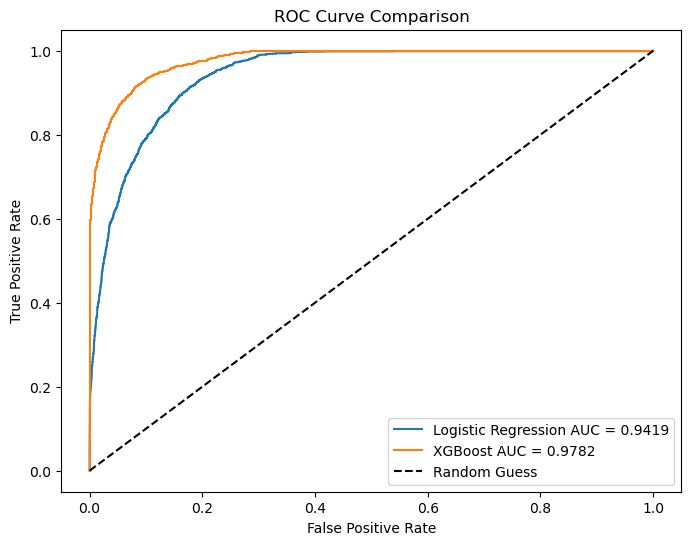

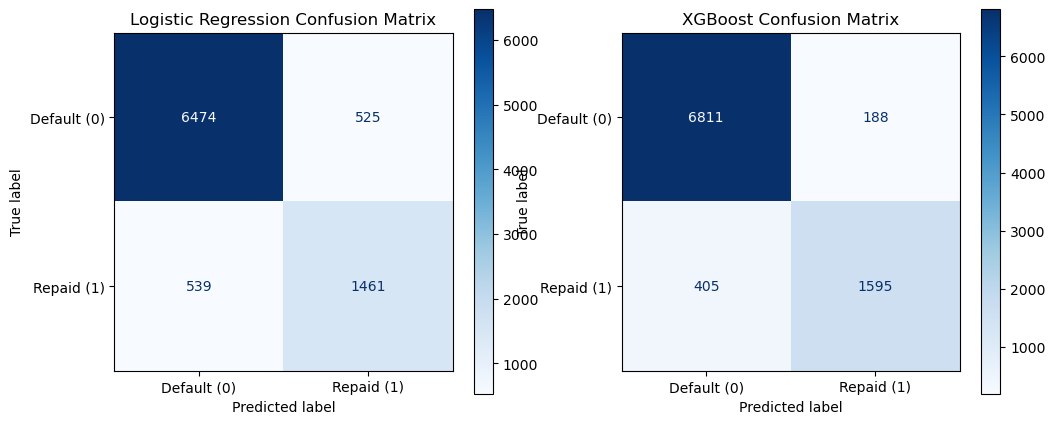

In [27]:
# Assuming df is your DataFrame and 'loan_status' is the target variable

# Define feature columns: all columns except 'loan_status'
feature_cols = [col for col in df.columns if col != 'loan_status']  # Include all except target
X = df[feature_cols]
y = df['loan_status']

# Identify categorical columns (including any derived ones like 'age_group')
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert categorical variables to numerical using one-hot encoding
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)
y_pred_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]

# Evaluate the Logistic Regression model
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
roc_auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

# Print Logistic Regression performance metrics
print("Logistic Regression Performance Metrics:")
print(f"Confusion Matrix:\n{conf_matrix_log_reg}")
print(f"ROC AUC Score: {roc_auc_log_reg}")
print(f"Accuracy: {accuracy_log_reg}")
print(f"Precision: {precision_log_reg}")
print(f"Recall: {recall_log_reg}")
print(f"F1 Score: {f1_log_reg}")

# Train the XGBoost model (using your final tuned parameters)
final_xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    n_estimators=245
)
final_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = final_xgb_model.predict(X_test)
y_pred_proba_xgb = final_xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the XGBoost model
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Print XGBoost performance metrics
print("\nXGBoost Performance Metrics:")
print(f"Confusion Matrix:\n{conf_matrix_xgb}")
print(f"ROC AUC Score: {roc_auc_xgb}")
print(f"Accuracy: {accuracy_xgb}")
print(f"Precision: {precision_xgb}")
print(f"Recall: {recall_xgb}")
print(f"F1 Score: {f1_xgb}")

# Compare the models
print("\nModel Comparison:")
print(f"ROC AUC Score - Logistic Regression: {roc_auc_log_reg} vs. XGBoost: {roc_auc_xgb}")
print(f"Accuracy - Logistic Regression: {accuracy_log_reg} vs. XGBoost: {accuracy_xgb}")
print(f"Precision - Logistic Regression: {precision_log_reg} vs. XGBoost: {precision_xgb}")
print(f"Recall - Logistic Regression: {recall_log_reg} vs. XGBoost: {recall_xgb}")
print(f"F1 Score - Logistic Regression: {f1_log_reg} vs. XGBoost: {f1_xgb}")

# Plot ROC curves for both models
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_proba_log_reg)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression AUC = {roc_auc_log_reg:.4f}')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost AUC = {roc_auc_xgb:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.show()

# Plot confusion matrices for both models
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_log_reg, display_labels=['Default (0)', 'Repaid (1)'])
disp_log_reg.plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Logistic Regression Confusion Matrix')

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, display_labels=['Default (0)', 'Repaid (1)'])
disp_xgb.plot(ax=ax[1], cmap='Blues')
ax[1].set_title('XGBoost Confusion Matrix')

plt.show()

Based on the results above, we found that the XGBoost model significantly outperforms the logistic regression model across all key performance metrics. The XGBoost model achieved a higher ROC AUC score of 0.978 compared to 0.942 for logistic regression. Additionally, the XGBoost model demonstrated higher accuracy (93.41% vs. 88.18%), precision (0.895 vs. 0.736), recall (0.798 vs. 0.731), and F1 score (0.843 vs. 0.733). These results suggest that the XGBoost model is more effective in predicting loan defaults and provides a more reliable and robust solution for this classification problem.

### XGBoost Model vs K-Means Model

In [28]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming df is your DataFrame and 'loan_status' is the target variable

# Define feature columns: all columns except 'loan_status'
feature_cols = [col for col in df.columns if col != 'loan_status']
X = df[feature_cols]

# Identify categorical columns (including any derived ones like 'age_group')
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert categorical variables to numerical using one-hot encoding
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Apply AgglomerativeClustering with k=2
agg_clustering = AgglomerativeClustering(n_clusters=2)
cluster_assignments = agg_clustering.fit_predict(X)

# Map clusters to original labels for comparison
# Since clusters are arbitrary, we need to map them to the actual classes
# We can do this by checking which cluster has a majority of which class

# Create a DataFrame to compare clusters with actual labels
comparison_df = pd.DataFrame({'Cluster': cluster_assignments, 'Actual': df['loan_status']})

# Calculate the majority class in each cluster
cluster_to_class = comparison_df.groupby('Cluster')['Actual'].agg(lambda x: x.value_counts().index[0])

# Map clusters to the majority class
mapped_clusters = comparison_df['Cluster'].map(cluster_to_class)

# Compare the mapped clusters to the actual labels
conf_matrix_clustering = confusion_matrix(df['loan_status'], mapped_clusters)
accuracy_clustering = accuracy_score(df['loan_status'], mapped_clusters)

# Print the results
print("Agglomerative Clustering Performance Metrics:")
print(f"Confusion Matrix:\n{conf_matrix_clustering}")
print(f"Accuracy: {accuracy_clustering}")

# Optionally, you can also calculate precision, recall, and F1 score if needed
precision_clustering = precision_score(df['loan_status'], mapped_clusters)
recall_clustering = recall_score(df['loan_status'], mapped_clusters)
f1_clustering = f1_score(df['loan_status'], mapped_clusters)

print(f"Precision: {precision_clustering}")
print(f"Recall: {recall_clustering}")
print(f"F1 Score: {f1_clustering}")

Agglomerative Clustering Performance Metrics:
Confusion Matrix:
[[34995     0]
 [10000     0]]
Accuracy: 0.777753083675964
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


C:\Users\madlin\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Based on the results above, we found that the K-Means clustering algorithm, when applied with k=2, did not perform well in identifying the two classes (loan default and loan repaid). The clustering algorithm assigned all data points to a single cluster, resulting in poor performance metrics such as zero precision, recall, and F1 score for one of the classes. Overall, it suggests that the clustering algorithm struggled to differentiate between the two classes based on the features provided.

# 7. Conclusion

In this assignment, we developed a predictive model to assess the likelihood of loan defaults using the XGBoost algorithm. Our primary objective was to identify key factors that influence loan repayment outcomes and evaluate the model's performance using appropriate metrics. Additionally, we explored the effectiveness of logistics and the K-Means clustering algorithms.

The XGBoost model demonstrated strong predictive performance with a test set AUC of 0.9787, indicating a high ability to differentiate between loans that will be repaid and those that will default. The model achieved high accuracy (93.41%), precision (0.89), recall (0.796), and F1 score (0.843), which suggests that it is effective in predicting loan defaults.
The most important feature in the model was previous_loan_defaults_on_file_Yes, followed by loan_percent_income, person_home_ownership_RENT, and loan_int_rate.

The XGBoost model significantly outperformed the logistic regression model across all key performance metrics. The K-Means clustering algorithm, when applied with k=2, did not perform well in identifying the two classes. One suggestion to improve the K-Means clustering is to apply dimensionality reduction technique such as PCA to reduce the complexity of the data and potentially improve clustering performance.

Overall, the XGBoost model provides a robust and effective solution for predicting loan defaults, while the K-Means clustering algorithm requires further refinement and exploration of additional techniques to improve its performance in identifying the two classes. The Logistic Regression model, while less effective than XGBoost, offers a simpler and interpretable alternative that can be further optimized.